In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import modules.evaluate as evaluate
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
import modules.random_graph as random_graph
import math
import random




modelLoads= ["AA", "AB", "BA", "BB", "infer2018"]
weightModels= ["degree", "gravity", "identical"]
randomGraphs= ["ER", "BA", "WS", "RGG"]
seeds= [10, 11, 12, 13, 14]
strains= [1, 2, 3, 4]
denses= [0, -1, -2, -3, -4]
nodes= [50, 100, 200, 400]
intenses= [0, 1, 2, -1]

identicalfs= [2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1]# except 1e-2

commands1=set()
linuxThread= 3

In [2]:
def continious_to_sparcity(my_array, top= 400):
    # Flatten the array to a 1D array
    flat_array = my_array.flatten()

    # Sort the flattened array in descending order
    sorted_indices = np.argsort(flat_array)[::-1]

    # Set the top 400 elements to 1 and the rest to 0
    flat_array[sorted_indices[:top]] = 1
    flat_array[sorted_indices[top:]] = 0

    # Reshape the modified 1D array back to the original shape
    result_array = flat_array.reshape(my_array.shape)
    return result_array

def continious_to_sparcity_cols(my_matrix, topRow= 8):

    result_matrix = np.zeros_like(my_matrix)
    indices = np.argsort(my_matrix, axis=1)[:, -topRow:]  # Get indices of top 8 elements in each row
    row_indices = np.arange(my_matrix.shape[0])[:, None]  # Row indices to broadcast
    result_matrix[row_indices, indices] = 1
    
    return result_matrix

def analyse_signal(signal):
    maxIndex = np.argmax(signal, axis= 2)
    signalCombine= signal.reshape(signal.shape[0], signal.shape[1]*signal.shape[2])
    meanV= maxIndex.mean()
    varV= np.var(maxIndex)
    simMatrix= cosine_similarity(signalCombine)
    simMatrixSumAVg= simMatrix.sum()/signal.shape[0]/signal.shape[0]
    return meanV, varV, simMatrixSumAVg

def scatter_points(x, y, xLabel="x", yLabel="y"):
    plt.scatter(x, y)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    pearson_corr = np.corrcoef(x, y)[0, 1]
    spearman_corr = np.corrcoef(np.argsort(x), np.argsort(y))[0, 1]
    kendall_corr, _ = kendalltau(x, y)
    print(f"Pearson correlation: {pearson_corr:.2f}, spearma correlation: {spearman_corr:.2f},  kendall correlation: {kendall_corr:.2f}")


(100, 4, 47)


(24.145, 61.568975, 0.2879723876953125)

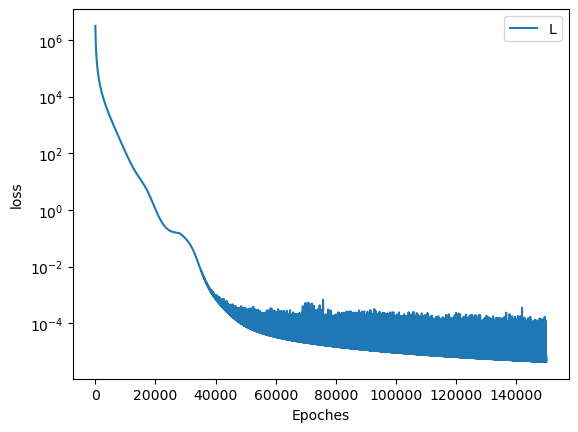

In [3]:
identicalf= 0.01

node= 100

strain= 4

#AA_RGG_identical_12_2_-1_0_100_10.0_150000
#AA_ER_identical_13_4_-1_0_100_10.0_150000
#AA_WS_identical_11_1_-1_0_100_10.0_150000
#AA_WS_identical_11_4_-1_0_100_10.0_150000

fileName= f"results/AA/AA_RGG_identical_{13}_{strain}_-1_0_100_{identicalf*1000}_150000.npz"
IMatrix= torch.eye(node, device= "cpu")
npzfile = np.load(fileName)
loss= npzfile['loss']
taus= npzfile["taus"]
signal= npzfile['signal']

plt.plot(loss)
plt.yscale("log")
plt.xlabel("Epoches")
plt.ylabel("loss")
plt.legend("Loss")


print(signal.shape)

analyse_signal(signal)

In [10]:
#AA_WS_identical_11_4_-1_0_100_10.0_150000

identicalf= 0.01
node= 100
#Is - jaccard index
cosinesL= []
spectralsL= []
edgesL= []
jaccardsL= []
meanVL= [] 
varVL= [] 
simMatrixSumAVgL= []
for randomGraph in randomGraphs:
    for dense in denses:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            try:
                fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{strain}_-1_{dense}_{node}_{identicalf*1000}_150000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                print(fileName)
                continue
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            signal= npzfile['signal']
            meanV, varV, simMatrixSumAVg= analyse_signal(signal)
            meanVL.append(meanV)
            varVL.append(varV)
            simMatrixSumAVgL.append(simMatrixSumAVg)
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosinesL.append(evaluate.cosine_similarity(Aw, PreA).item())
            spectralsL.append(evaluate.spectral_analysis(Aw, PreA).item())
            edgesL.append(evaluate.recall(Aw, PreA).item())
            jaccardsL.append(evaluate.jaccard_index(Aw, PreA).item())

Pearson correlation: 0.74, spearma correlation: 0.51,  kendall correlation: 0.57


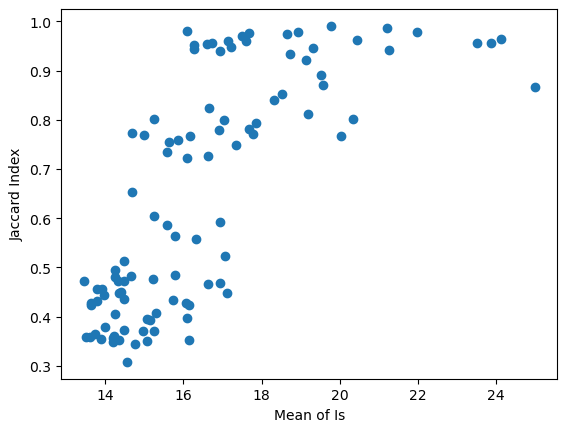

In [11]:
scatter_points(meanVL, jaccardsL, "Mean of Is","Jaccard Index" )

Pearson correlation: 0.69, spearma correlation: 0.65,  kendall correlation: 0.72


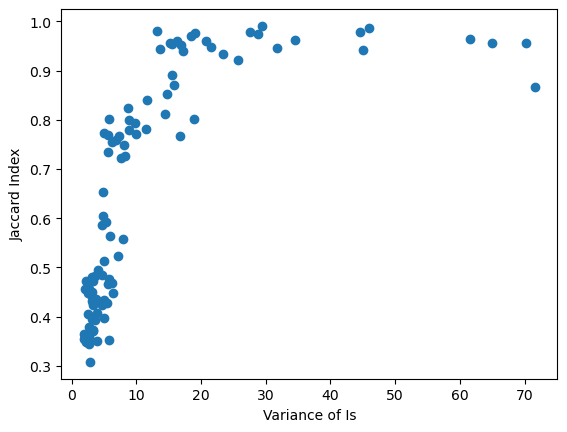

In [12]:
scatter_points(varVL, jaccardsL, "Variance of Is", "Jaccard Index" )

Pearson correlation: -0.94, spearma correlation: -0.71,  kendall correlation: -0.74


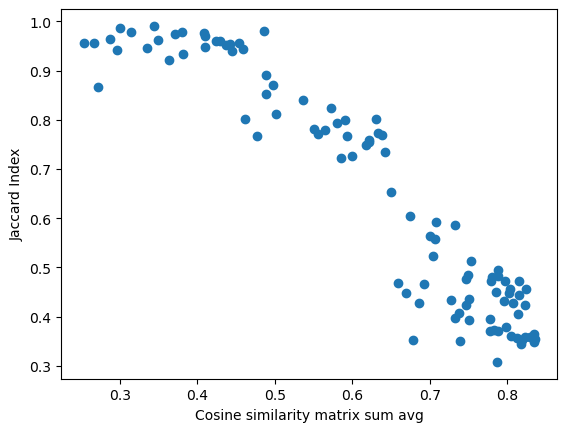

In [13]:
scatter_points(simMatrixSumAVgL, jaccardsL, "Cosine similarity matrix sum avg", "Jaccard Index" )

In [14]:
#train svm classier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVR  # For SVM regression

model = SVR(kernel='linear')  # Adjust kernel as needed
x_train_np= np.stack(meanVL)
y_train_np= np.stack(varVL)
z_train_np= np.stack(simMatrixSumAVgL)
g_train_np= np.stack(jaccardsL)
model.fit(np.stack([x_train_np, y_train_np, z_train_np], axis=1), g_train_np)

g_pred_np = model.predict(np.stack([x_train_np, y_train_np, z_train_np], axis=1))

print(np.mean(np.abs(g_train_np-g_pred_np)))
print(np.var(np.abs(g_train_np-g_pred_np)))

0.06521520857316827
0.0020942440578151887


In [16]:
import modules.random_graph as random_graph
import modules.pramameters as pramameters
import modules.utils as utils
import modules.weight as weight
import modules.A_mat as A_mat
import modules.population as population
import modules.simulation as simulation
import argparse



#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
#preset
paras.modelLoad= "AA"
paras.randomGraph= "ER"
paras.weightModel= "identical"
paras.epoches= 100000
paras.intense= -1
paras.seed= 13
paras.plot= "spring"
paras.strains= 4
paras.dense= 0
paras.identicalf= 0.01
paras.n= 100

if paras.dense<=0:
    paras.dense= int(math.log(paras.n))-paras.dense
    print(paras.dense)

A, G= random_graph.get_BA_random_contact(paras.n, paras.dense-2)

P= population.population(paras.n)

Zmat= A_mat.create_A_mat(Aw, P)
Aw= weight.identical_model(A, paras.identicalf)

R0s_taus= [[random.uniform(paras.R0Mean-paras.R0Std, paras.R0Mean+paras.R0Std), 
            random.uniform(paras.tauMean-paras.tauStd, paras.tauMean+paras.tauStd)] for _ in range(40)]
paras.R0s=  [ R0s_taus[i][0] for i in range(40)]
paras.taus= [ R0s_taus[i][1] for i in range(40)]

deltaSsTensor= simulation.multi_strains(G, paras, Zmat, intense= paras.intense, lower= 50)
deltaSs= deltaSsTensor.sum(dim= -1, keepdim= True)
propition= deltaSsTensor/(deltaSs+1e-8)
deltaSs= deltaSs.squeeze()#(1, 2, 20), dim of nodes, dim of heads, dim of signal
divide= deltaSsTensor.transpose(1, 2)

meanV, varV, simMatrixSumAVg= analyse_signal(divide.numpy())

print(meanV, varV, simMatrixSumAVg)
print(model.predict(np.array([[meanV, varV, simMatrixSumAVg]])))

4
18.49 11.2799 0.62502109375
[0.63092648]


In [11]:
# from datetime import datetime
# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# # Specify the file path
# file_path = f"graphs/er_{timestamp}.npy"
# # Save the matrix to a file
# np.save(file_path, A.numpy())
# print(f"NumPy matrix saved to file: {file_path}")

NumPy matrix saved to file: graphs/er_2024-01-03_11-49-18.npy


In [55]:

identicalf= 0.01
node= 50
strain= 4

#Performance on different models

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    for modelLoad in modelLoads:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        minus= 0
        for seed in seeds:
            try:
                if modelLoad=="AA":
                    fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{strain}_0_8_50_{identicalf*1000}_140000.npz"
                else:
                    fileName= f"results/{modelLoad}/{modelLoad}_{randomGraph}_identical_{seed}_{strain}_0_100000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                #print(fileName)
                minus+=1
                continue
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.precision(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)-minus
        spectrals/= len(seeds)-minus
        edges/= len(seeds)-minus
        jaccards/= len(seeds)-minus
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList))
    #print()

0.74	0.55	0.33	0.56	0.57	0.51	0.60	0.49	0.46	0.58	0.69	0.38	0.38	0.56	0.57	0.52	0.23	0.23	0.39	0.40
0.77	0.51	0.33	0.53	0.55	0.49	0.63	0.54	0.49	0.53	0.74	0.35	0.37	0.57	0.58	0.59	0.21	0.23	0.40	0.41
0.77	0.56	0.34	0.60	0.61	0.70	0.59	0.67	0.68	0.64	0.75	0.39	0.39	0.62	0.61	0.60	0.25	0.24	0.45	0.44
0.93	0.64	0.47	0.58	0.60	0.93	0.74	0.79	0.85	0.82	0.97	0.52	0.52	0.74	0.75	0.95	0.35	0.35	0.59	0.60


In [83]:
def general_evaluate(evaluateMeth=[], attriIndex= 0, attributionL=[] ,seed= 100001, CompareWithRandom= False):
    random.seed(seed)
    strain= 4
    intense= -1
    dense= 0
    node= 100
    identicalf= 0.01
    epoches= 150000
    atts= [strain, intense, dense, node, identicalf, epoches]
    auc_rocs_aws= []
    auc_rocs_preA= []
    evaluateLists= []
    for randomGraph in randomGraphs:
        evaluateList= []
        for attribution in attributionL: 
            atts[attriIndex]= attribution
            evaluateNp= [0 for _ in range(len(evaluateMeth))]
            auc_rocs_aws_temp= []
            auc_rocs_preA_temp= []
            for seed in seeds:
                try:
                    fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{atts[0]}_{atts[1]}_{atts[2]}_{atts[3]}_{atts[4]*1000}_{atts[5]}.npz"
                    IMatrix= torch.eye(atts[3], device= "cpu")
                    npzfile = np.load(fileName)
                except:
                    print(fileName)
                    continue
                # Access the arrays in the NPZ file
                Awnp= npzfile['A']
                PreAnp= npzfile['Apre']
                if CompareWithRandom:
                    denseTrue= int(math.log(node))-atts[2]
                    A, _= random_graph.get_ER_random_contact(node, denseTrue, shuffle= True)
                    PreAnp= A.numpy()
                Aw = torch.tensor(Awnp)
                PreA = torch.tensor(PreAnp)
                
                links= int(torch.sum(Aw)/identicalf)  
                Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
                for i, method in enumerate(evaluateMeth):
                    evaluateNp[i]+= method(Aw, PreA)
                auc_rocs_aws_temp.append(Aws-IMatrix)
                auc_rocs_preA_temp.append(PreA)
            for i, _ in enumerate(evaluateMeth):
                evaluateNp[i]= round(evaluateNp[i].item()/len(seeds), 2)
            evaluateList.append(evaluateNp)
            #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
            auc_rocs_aws.append(torch.stack(auc_rocs_aws_temp))
            auc_rocs_preA.append(torch.stack(auc_rocs_preA_temp))
        strPrint=""
        evaluateLists.append(evaluateList)
        for i, _ in enumerate(attributionL):
            strPrint+= "\t".join([str(j) for j in evaluateList[i]])+"\t"
        print(strPrint)
    return auc_rocs_aws, auc_rocs_preA, evaluateLists

def plot_evaluate(xs, evaluateArray, xLabel, yLabels, legends, xScale="linear", yScale="linear"):

    fig, axs = plt.subplots(int((len(yLabels)+2)/3), 3, figsize=(8*int((len(yLabels)+2)/3), 8))
    for i, yLabel in enumerate(yLabels):
        axs[int(i/3), i%3].plot(xs , evaluateArray[:, :, i].T)
        axs[int(i/3), i%3].set_xlabel(xLabel)
        axs[int(i/3), i%3].set_ylabel(str(yLabel))
        axs[int(i/3), i%3].legend(legends)
        axs[int(i/3), i%3].set_xscale(xScale)
        axs[int(i/3), i%3].set_yscale(yScale)


0.31	0.33	0.31	0.19	0.88	0.5	0.28	0.45	0.29	0.9	0.58	0.26	0.52	0.36	0.91	0.65	0.2	0.6	0.43	0.93	
0.43	0.37	0.44	0.28	0.9	0.6	0.43	0.57	0.39	0.92	0.65	0.34	0.62	0.45	0.93	0.74	0.21	0.72	0.56	0.95	
0.24	0.34	0.33	0.2	0.88	0.7	0.62	0.67	0.5	0.94	0.82	0.75	0.82	0.7	0.97	0.89	0.78	0.91	0.83	0.98	
0.44	0.55	0.49	0.34	0.91	0.84	0.78	0.83	0.72	0.97	0.92	0.84	0.92	0.86	0.99	0.96	0.83	0.97	0.94	0.99	


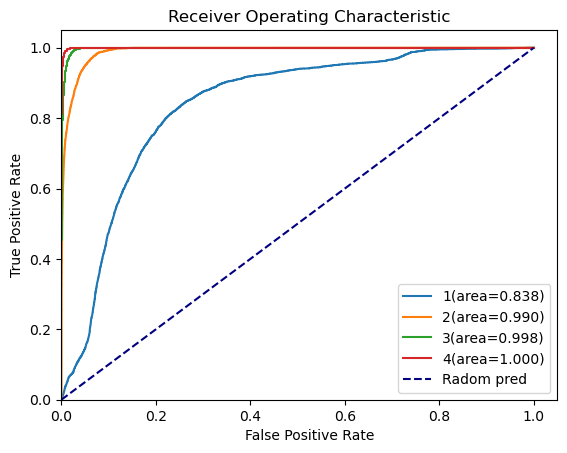

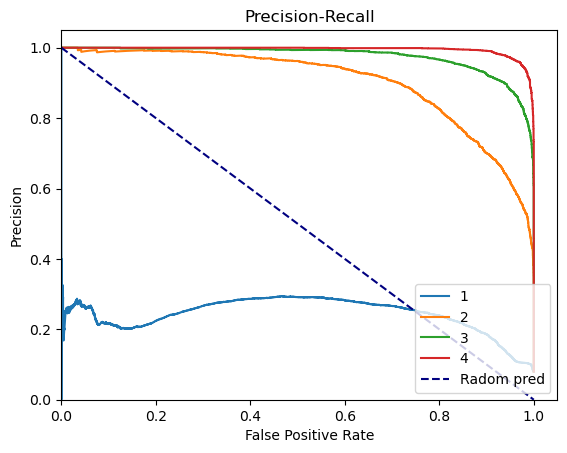

In [79]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index, evaluate.accuracy]
attriIndex= 0 
attributionL= strains
auc_rocs_aws, auc_rocs_preA, _= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 0, attributionL=strains ,seed= 100001, CompareWithRandom= False)

startIn= 3*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)

0.31	0.33	0.31	0.19	0.88	0.5	0.28	0.45	0.29	0.9	0.58	0.26	0.52	0.36	0.91	0.65	0.2	0.6	0.43	0.93	
0.43	0.37	0.44	0.28	0.9	0.6	0.43	0.57	0.39	0.92	0.65	0.34	0.62	0.45	0.93	0.74	0.21	0.72	0.56	0.95	
0.24	0.34	0.33	0.2	0.88	0.7	0.62	0.67	0.5	0.94	0.82	0.75	0.82	0.7	0.97	0.89	0.78	0.91	0.83	0.98	
0.44	0.55	0.49	0.34	0.91	0.84	0.78	0.83	0.72	0.97	0.92	0.84	0.92	0.86	0.99	0.96	0.83	0.97	0.94	0.99	


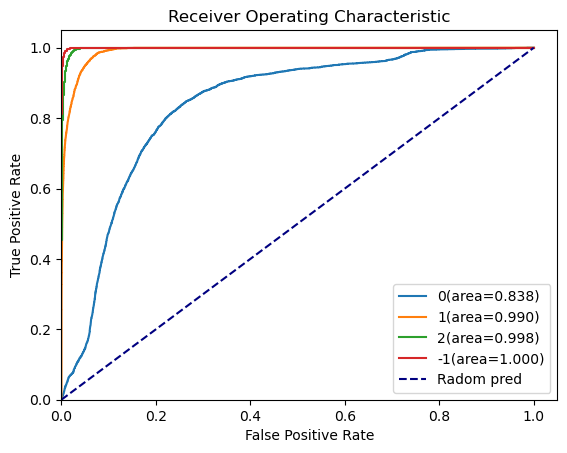

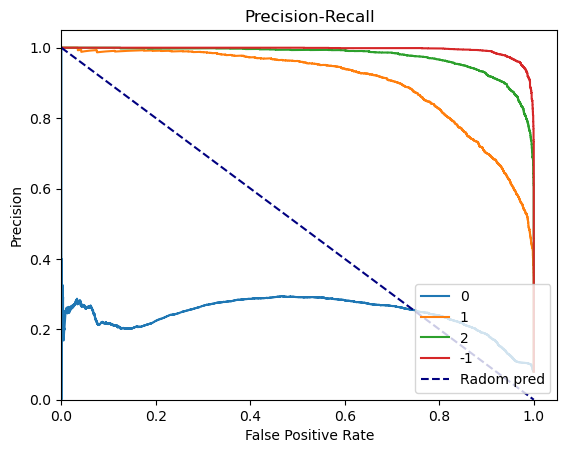

In [89]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index, evaluate.accuracy]
attriIndex= 1 
attributionL= intenses
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 0, attributionL=strains ,seed= 100001, CompareWithRandom= False)

startIn= 3*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)

0.65	0.2	0.6	0.43	0.96	0.93	0.62	0.22	0.57	0.4	0.95	0.9	0.6	0.32	0.53	0.36	0.93	0.88	0.6	0.19	0.53	0.36	0.92	0.86	0.6	0.33	0.53	0.36	0.9	0.84	
0.74	0.21	0.72	0.56	0.97	0.95	0.68	0.38	0.64	0.47	0.96	0.92	0.69	0.43	0.65	0.48	0.95	0.91	0.67	0.36	0.62	0.45	0.94	0.89	0.66	0.48	0.61	0.44	0.93	0.88	
0.89	0.78	0.91	0.83	0.99	0.98	0.88	0.75	0.89	0.81	0.99	0.98	0.86	0.83	0.87	0.78	0.98	0.97	0.85	0.83	0.86	0.75	0.97	0.96	0.83	0.83	0.84	0.72	0.97	0.94	
0.96	0.83	0.97	0.94	1.0	0.99	0.96	0.83	0.98	0.96	1.0	1.0	0.96	0.84	0.98	0.97	1.0	1.0	0.95	0.88	0.98	0.96	1.0	0.99	0.95	0.9	0.98	0.96	1.0	0.99	


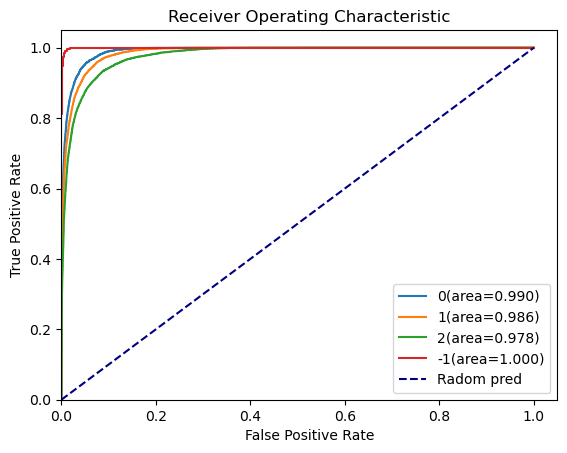

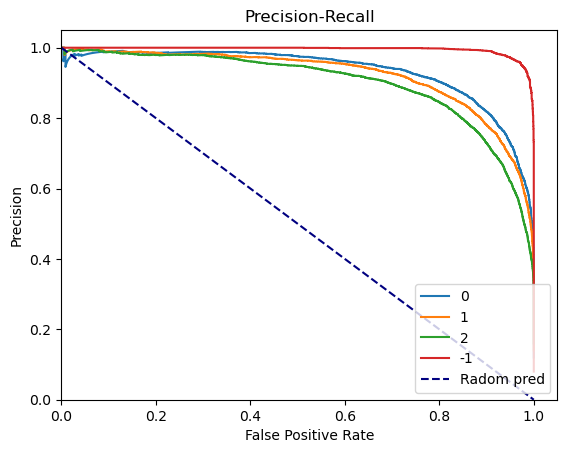

In [92]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index, evaluate.negative_predictive, evaluate.accuracy]
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 2, attributionL= denses ,seed= 100001, CompareWithRandom= False)
evaluateArray= np.array(evaluateLists)
startIn= 3*len(attributionL)
endIn= len(attributionL)+startIn
yLabels= [str(i).split()[1] for i in evaluateMeth]
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)

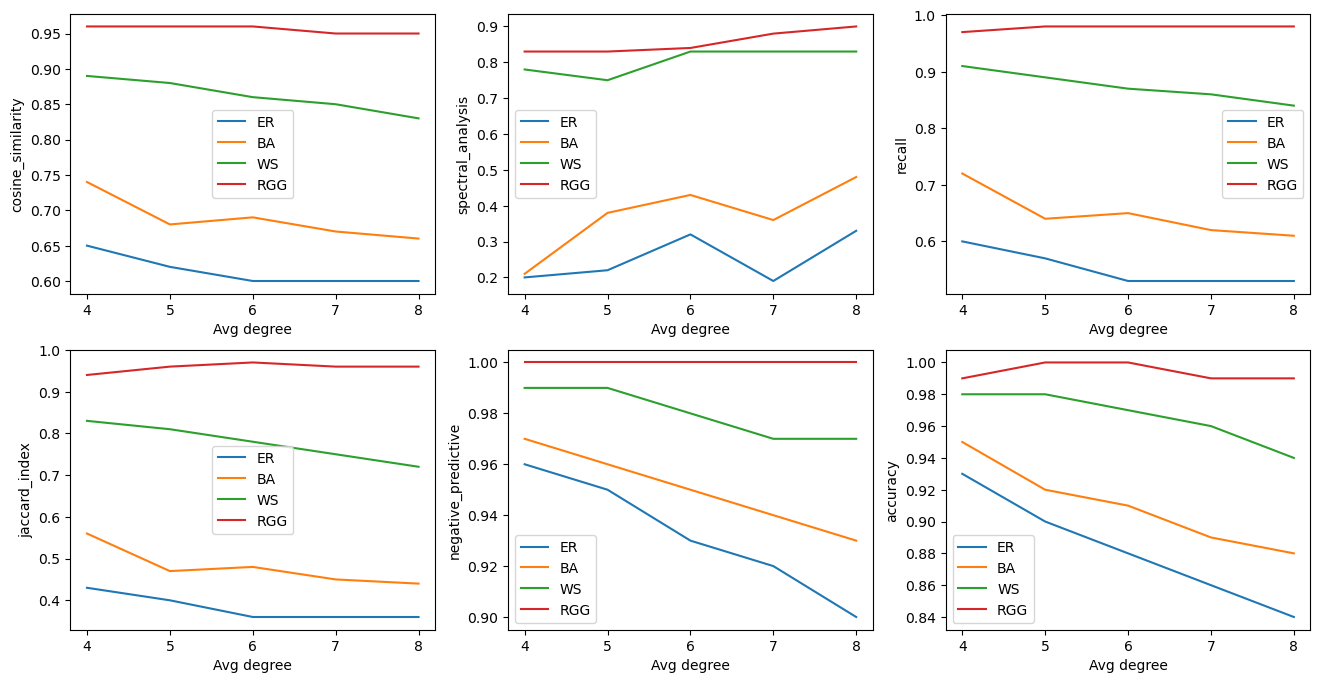

In [93]:
plot_evaluate(int(math.log(100))-np.array(denses), evaluateArray, "Avg degree", yLabels, randomGraphs)

In [67]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index, evaluate.negative_predictive, evaluate.accuracy]
attriIndex= 1 
attributionL= intenses
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 3, attributionL= nodes ,seed= 100001, CompareWithRandom= False)
evaluateArray= np.array(evaluateLists)
yLabels= [str(i).split()[1] for i in evaluateMeth]

0.87	0.18	0.86	0.76	0.98	0.96	0.65	0.2	0.6	0.43	0.96	0.93	0.5	0.12	0.45	0.29	0.97	0.94	0.38	0.21	0.34	0.2	0.98	0.96	
0.88	0.45	0.89	0.81	0.98	0.97	0.74	0.21	0.72	0.56	0.97	0.95	0.58	0.12	0.55	0.38	0.97	0.95	0.5	0.22	0.47	0.31	0.99	0.97	
0.97	0.76	0.98	0.97	1.0	1.0	0.89	0.78	0.91	0.83	0.99	0.98	0.79	0.76	0.79	0.65	0.99	0.98	0.74	0.68	0.73	0.58	0.99	0.99	
0.98	0.9	0.99	0.98	1.0	1.0	0.96	0.83	0.97	0.94	1.0	0.99	0.94	0.77	0.96	0.92	1.0	1.0	0.92	0.78	0.93	0.88	1.0	1.0	


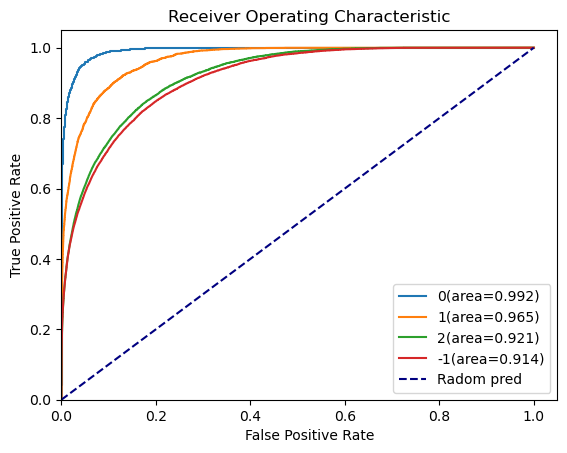

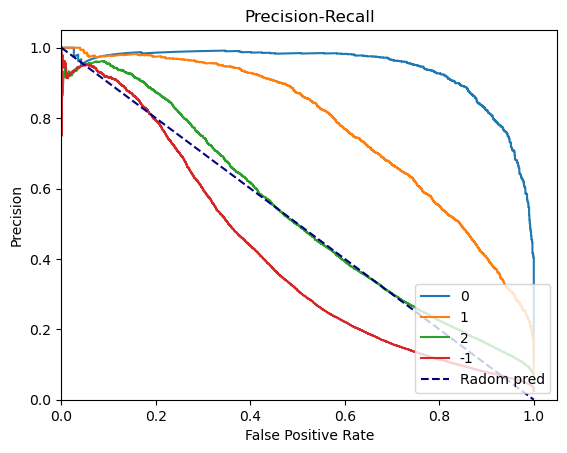

In [63]:
startIn= 1*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)

In [101]:
import networkx as nx
Anp= np.load("graphs/ba1.npy")
graph = nx.from_numpy_array(Anp)


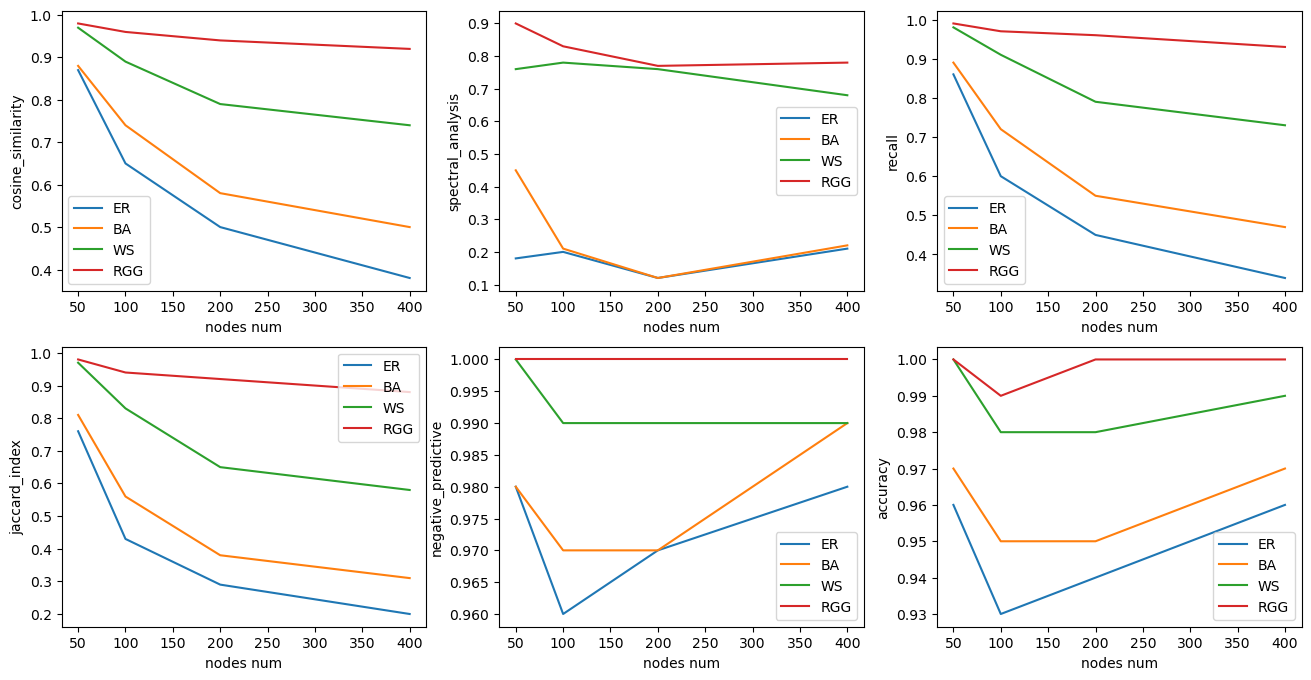

In [68]:
plot_evaluate(nodes, evaluateArray, "nodes num", yLabels, randomGraphs)

In [72]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index, evaluate.negative_predictive, evaluate.accuracy]
attriIndex= 1 
attributionL= intenses
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 1, attributionL= intenses ,seed= 100001, CompareWithRandom= False)
evaluateArray= np.array(evaluateLists)
yLabels= [str(i).split()[1] for i in evaluateMeth]

0.66	0.25	0.62	0.45	0.96	0.93	0.66	0.19	0.62	0.45	0.96	0.93	0.64	0.21	0.6	0.43	0.96	0.93	0.65	0.2	0.6	0.43	0.96	0.93	
0.75	0.3	0.73	0.58	0.97	0.95	0.75	0.37	0.73	0.58	0.97	0.95	0.74	0.28	0.71	0.56	0.97	0.95	0.74	0.21	0.72	0.56	0.97	0.95	
0.89	0.72	0.9	0.83	0.99	0.98	0.9	0.73	0.92	0.84	0.99	0.98	0.9	0.77	0.92	0.84	0.99	0.98	0.89	0.78	0.91	0.83	0.99	0.98	
0.97	0.86	0.98	0.96	1.0	1.0	0.97	0.82	0.98	0.97	1.0	1.0	0.95	0.82	0.96	0.92	1.0	0.99	0.96	0.83	0.97	0.94	1.0	0.99	


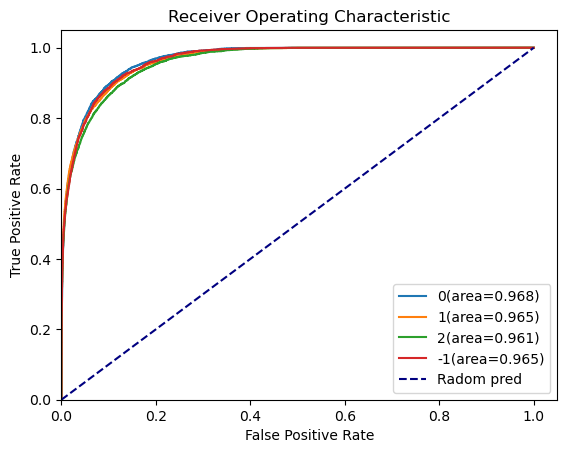

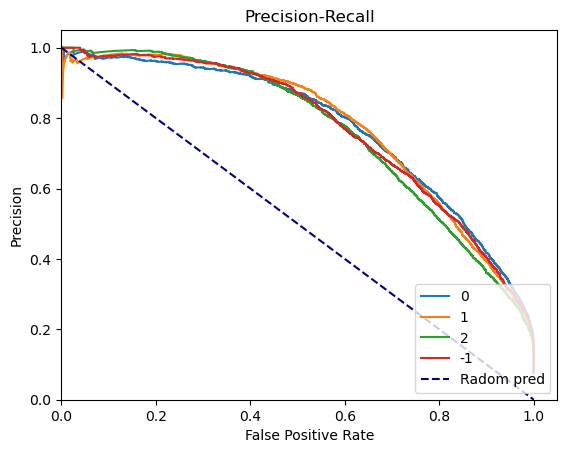

In [70]:
startIn= 1*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)

In [85]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index, evaluate.negative_predictive, evaluate.accuracy]
attriIndex= 1 
attributionL= intenses
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 4, attributionL= identicalfs, seed= 100001, CompareWithRandom= False)
evaluateArray= np.array(evaluateLists)
yLabels= [str(i).split()[1] for i in evaluateMeth]

0.58	0.22	0.55	0.38	0.96	0.92	0.62	0.25	0.59	0.42	0.96	0.93	0.66	0.17	0.62	0.46	0.96	0.93	0.67	0.2	0.63	0.46	0.96	0.93	0.66	0.19	0.63	0.46	0.96	0.93	0.65	0.2	0.6	0.43	0.96	0.93	0.64	0.24	0.59	0.42	0.96	0.93	0.62	0.19	0.57	0.4	0.96	0.92	0.29	0.24	0.4	0.25	0.94	0.89	
0.62	0.34	0.61	0.44	0.96	0.93	0.7	0.3	0.69	0.52	0.97	0.95	0.71	0.3	0.7	0.54	0.97	0.95	0.74	0.2	0.72	0.57	0.97	0.95	0.74	0.3	0.72	0.56	0.97	0.95	0.74	0.21	0.72	0.56	0.97	0.95	0.74	0.3	0.71	0.55	0.97	0.95	0.56	0.21	0.64	0.48	0.97	0.94	0.28	0.25	0.43	0.27	0.95	0.9	
0.81	0.72	0.82	0.7	0.98	0.97	0.88	0.76	0.89	0.8	0.99	0.98	0.9	0.76	0.92	0.85	0.99	0.99	0.91	0.79	0.93	0.86	0.99	0.99	0.9	0.75	0.91	0.84	0.99	0.98	0.89	0.78	0.91	0.83	0.99	0.98	0.88	0.76	0.89	0.8	0.99	0.98	0.88	0.76	0.89	0.8	0.99	0.98	0.75	0.77	0.81	0.68	0.98	0.97	
0.89	0.78	0.89	0.81	0.99	0.98	0.93	0.82	0.94	0.89	0.99	0.99	0.94	0.8	0.94	0.89	0.99	0.99	0.96	0.82	0.96	0.93	1.0	0.99	0.95	0.84	0.96	0.92	1.0	0.99	0.96	0.83	0.97	0.94	1.0	0.99	0.95	0.84	0.96	0.93	1.0	0.99	0

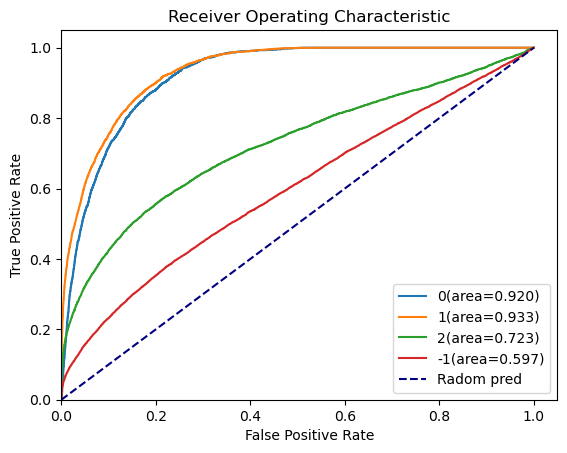

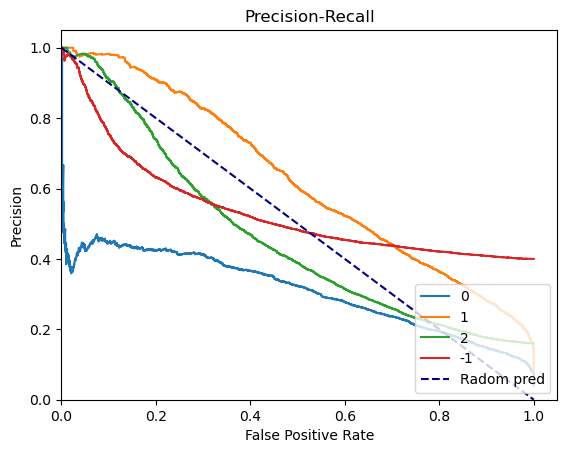

In [86]:
startIn= 1*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)

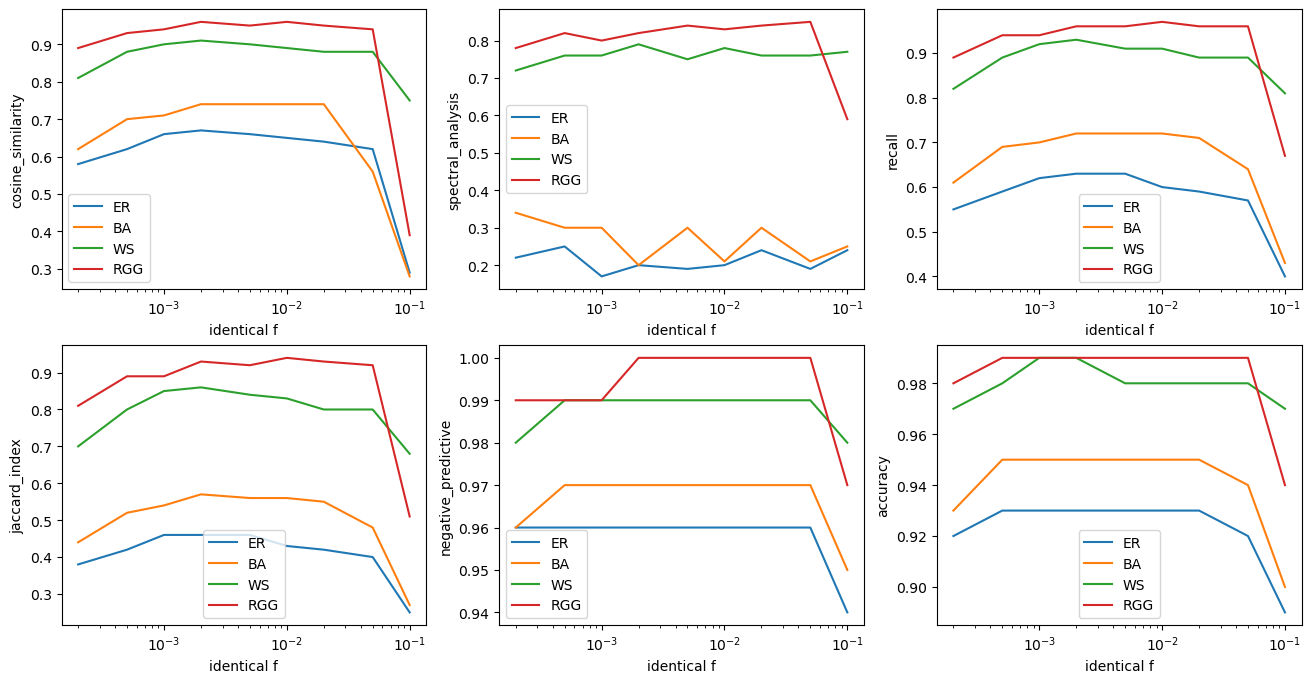

In [88]:
plot_evaluate(identicalfs, evaluateArray, "identical f", yLabels, randomGraphs, "log")